In [1]:
# Codeblock 1
import os
import torch

import torch.nn as nn
import torch.optim as optim
import torchvision.models as models
import matplotlib.pyplot as plt

from PIL import Image
from tqdm import tqdm
from torchvision import transforms
from torchvision.models import VGG19_Weights
from torchvision.utils import save_image

In [2]:
# Codeblock 2
device = torch.device('cuda' if torch.cuda.is_available else 'cpu')

In [3]:
# Codeblock 3
IMAGE_SIZE    = 224    #(1)
EPOCHS        = 20001  #(2)
LEARNING_RATE = 0.001  #(3)
ALPHA         = 1      #(4)
BETA          = 1000   #(5)

In [4]:
# Codeblock 4
def load_image(filename, image_size=IMAGE_SIZE):
    
    transform = transforms.Compose([
        transforms.Resize(image_size),  #(1)
        transforms.ToTensor(),  #(2)
        transforms.Normalize(mean=[0.485, 0.456, 0.406],  #(3)
                             std=[0.229, 0.224, 0.225])
    ])
    
    image = Image.open(filename)  #(4)
    image = transform(image)  #(5)
    image = image.unsqueeze(0)  #(6)
    
    return image

In [5]:
# Codeblock 5
content_image = load_image('Victoria Library.jpg').to(device)  #(1)
style_image = load_image('Starry Night.jpg').to(device)  #(2)
gen_image = content_image.clone().requires_grad_(True)  #(3)

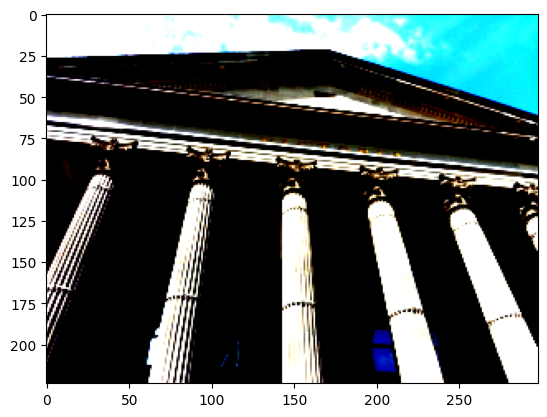

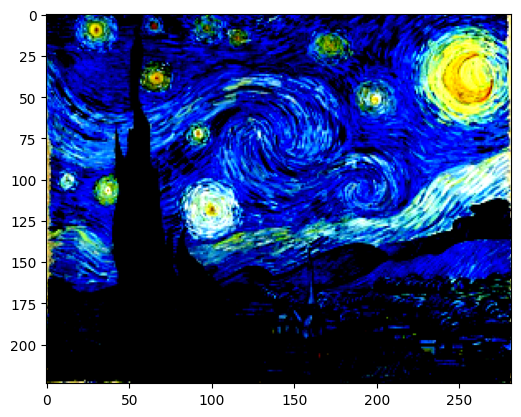

In [6]:
# Codeblock 6
plt.imshow(content_image.permute(0, 2, 3, 1).squeeze().to('cpu'))
plt.show()

plt.imshow(style_image.permute(0, 2, 3, 1).squeeze().to('cpu'))
plt.show()

In [7]:
# Codeblock 7
models.vgg19(weights=VGG19_Weights.IMAGENET1K_V1)

Downloading: "https://download.pytorch.org/models/vgg19-dcbb9e9d.pth" to /root/.cache/torch/hub/checkpoints/vgg19-dcbb9e9d.pth
100%|██████████| 548M/548M [00:02<00:00, 205MB/s]


VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padd

In [8]:
# Codeblock 8
class ModifiedVGG(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.layer_content_idx = [21]  #(1)
        self.layer_style_idx = [0, 5, 10, 19, 28]  #(2)
        
        #(3)
        self.model = models.vgg19(weights=VGG19_Weights.IMAGENET1K_V1).features[:29]
    
    def forward(self, x):

        content_features = []  #(4)
        style_features = []    #(5)
        
        for layer_idx, layer in enumerate(self.model):
            x = layer(x)  #(6)
            
            if layer_idx in self.layer_content_idx:
                content_features.append(x)  #(7)
            
            if layer_idx in self.layer_style_idx:
                style_features.append(x)  #(8)
 
        return content_features, style_features  #(9)

In [9]:
# Codeblock 9
modified_vgg = ModifiedVGG().to(device).eval()  #(1)

content_features = modified_vgg(content_image)[0]  #(2)
style_features = modified_vgg(style_image)[1]  #(3)

print('content_features length\t:', len(content_features))
print('style_features length\t:', len(style_features))

content_features length	: 1
style_features length	: 5


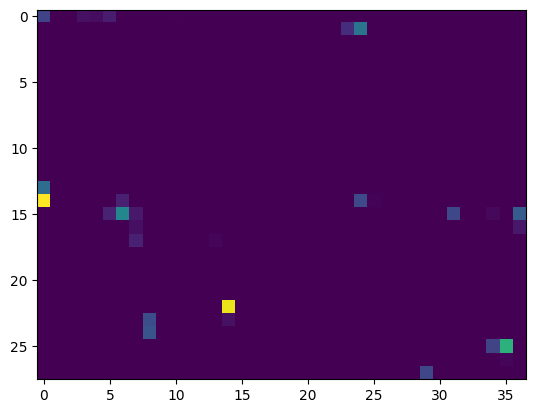

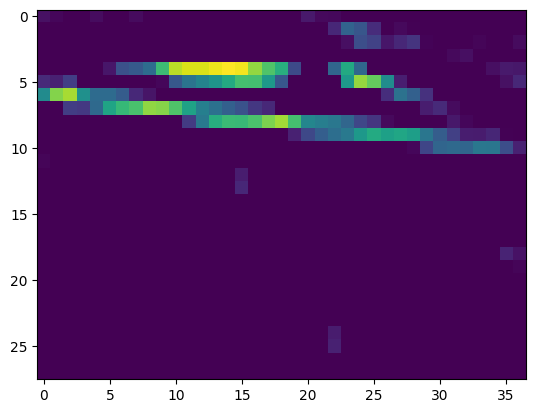

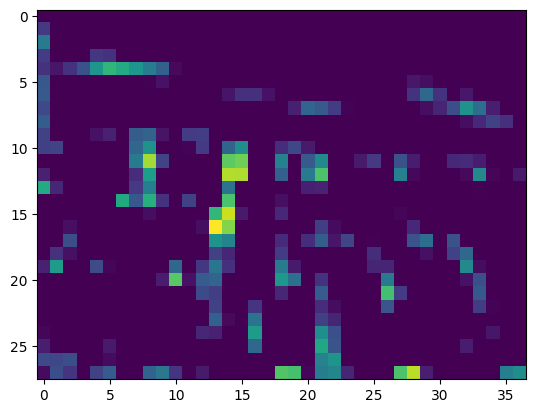

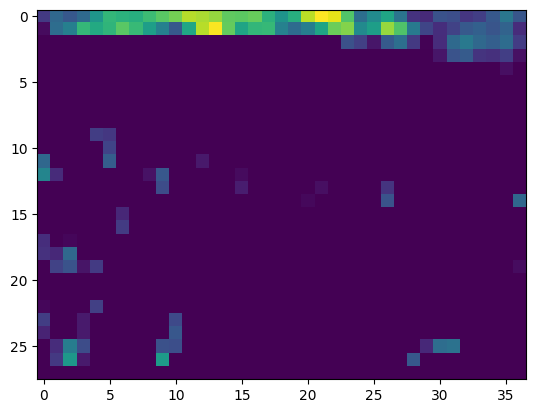

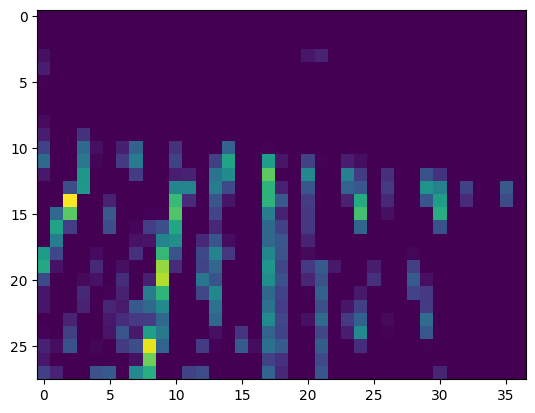

In [10]:
# Codeblock 10
plt.imshow(content_features[0].permute(0, 2, 3, 1).squeeze()[:,:,0].to('cpu').detach())
plt.show()

plt.imshow(content_features[0].permute(0, 2, 3, 1).squeeze()[:,:,1].to('cpu').detach())
plt.show()

plt.imshow(content_features[0].permute(0, 2, 3, 1).squeeze()[:,:,2].to('cpu').detach())
plt.show()

plt.imshow(content_features[0].permute(0, 2, 3, 1).squeeze()[:,:,3].to('cpu').detach())
plt.show()

plt.imshow(content_features[0].permute(0, 2, 3, 1).squeeze()[:,:,4].to('cpu').detach())
plt.show()

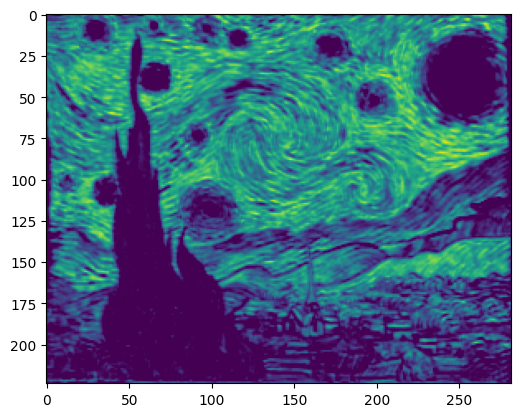

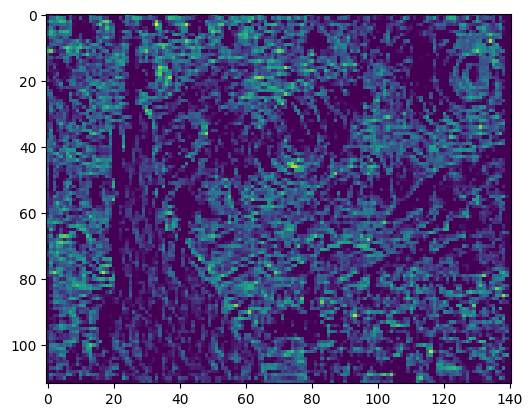

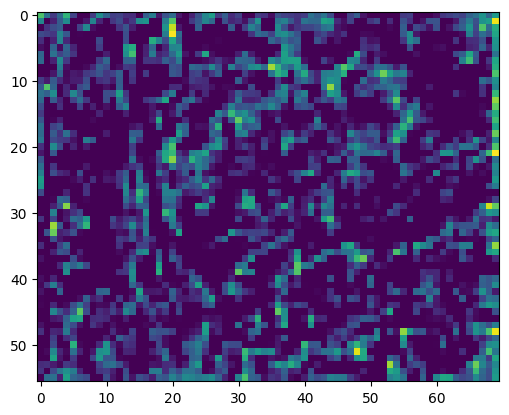

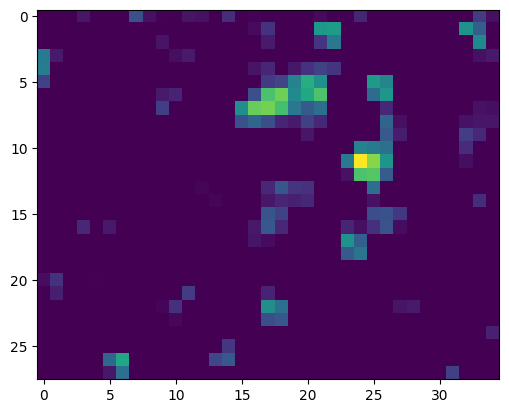

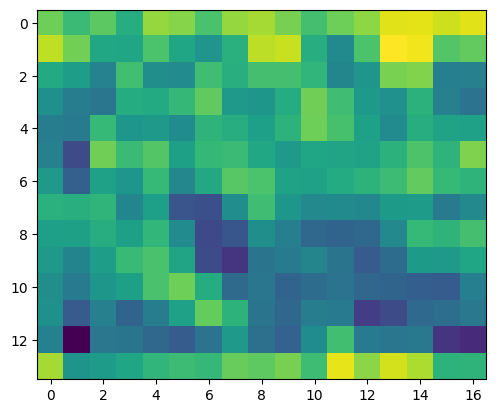

In [11]:
# Codeblock 11
plt.imshow(style_features[0].permute(0, 2, 3, 1).squeeze()[:,:,60].to('cpu').detach())
plt.show()

plt.imshow(style_features[1].permute(0, 2, 3, 1).squeeze()[:,:,12].to('cpu').detach())
plt.show()

plt.imshow(style_features[2].permute(0, 2, 3, 1).squeeze()[:,:,71].to('cpu').detach())
plt.show()

plt.imshow(style_features[3].permute(0, 2, 3, 1).squeeze()[:,:,152].to('cpu').detach())
plt.show()

plt.imshow(style_features[4].permute(0, 2, 3, 1).squeeze()[:,:,76].to('cpu').detach())
plt.show()

In [12]:
# Codeblock 12
def compute_gram_matrix(feature_map):
    batch_size, num_channels, height, width = feature_map.shape
    
    feature_map_flat = feature_map.view(num_channels, height*width)  #(1) 
    gram_matrix = torch.matmul(feature_map_flat, feature_map_flat.t())  #(2)
    
    return gram_matrix

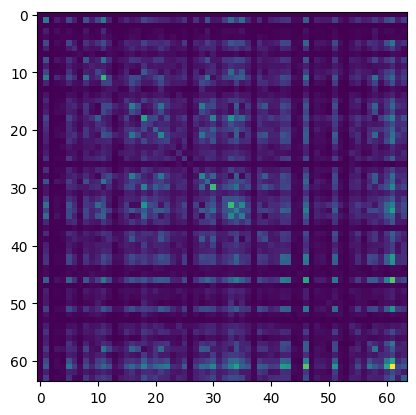

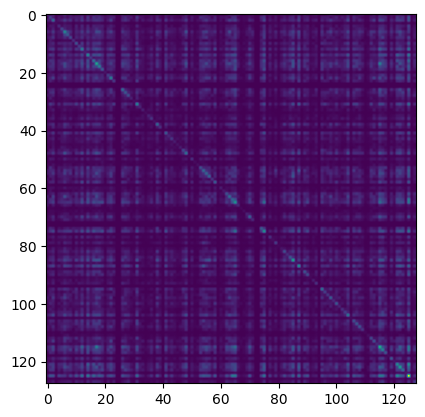

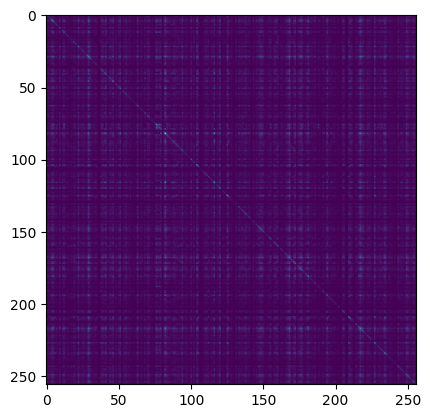

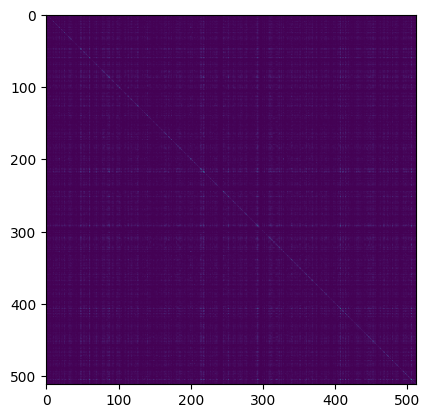

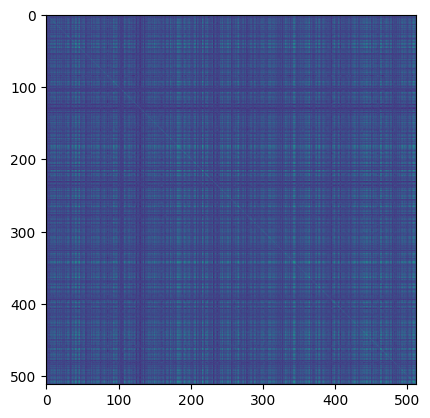

In [13]:
# Codeblock 13
style_features_0 = compute_gram_matrix(style_features[0])
style_features_1 = compute_gram_matrix(style_features[1])
style_features_2 = compute_gram_matrix(style_features[2])
style_features_3 = compute_gram_matrix(style_features[3])
style_features_4 = compute_gram_matrix(style_features[4])

plt.imshow(style_features_0.to('cpu').detach())
plt.show()

plt.imshow(style_features_1.to('cpu').detach())
plt.show()

plt.imshow(style_features_2.to('cpu').detach())
plt.show()

plt.imshow(style_features_3.to('cpu').detach())
plt.show()

plt.imshow(style_features_4.to('cpu').detach())
plt.show()

In [14]:
# Codeblock 14
def MSE(tensor_0, tensor_1):
    return torch.mean((tensor_0-tensor_1)**2)

optimizer = optim.Adam(params=[gen_image], lr=LEARNING_RATE)

In [15]:
# Codeblock 15
def denormalize(gen_image):
    mean = torch.tensor([0.485, 0.456, 0.406], device=device).view(1, 3, 1, 1)  #(1)
    std = torch.tensor([0.229, 0.224, 0.225], device=device).view(1, 3, 1, 1)  #(2)
    
    gen_image = gen_image*std + mean  #(3)
    
    return gen_image

In [16]:
# Codeblock 16a
def optimize():
    
    #(1)
    content_losses = []
    style_losses = []
    total_losses = []
    
    for epoch in tqdm(range(EPOCHS)):
        content_features = modified_vgg(content_image)[0]  #(2)
        style_features = modified_vgg(style_image)[1]  #(3)
        
        gen_features = modified_vgg(gen_image)
        gen_features_content, gen_features_style = gen_features  #(4)
        
# Codeblock 16b
        content_loss = 0  #(1)
        style_loss = 0  #(2)
        
        for content_feature, gen_feature_content in zip(content_features, gen_features_content):
            content_loss += MSE(content_feature, gen_feature_content)  #(3)
            
        for style_feature, gen_feature_style in zip(style_features, gen_features_style):
            
            style_gram = compute_gram_matrix(style_feature)  #(4)
            gen_gram = compute_gram_matrix(gen_feature_style)  #(5)
            
            style_loss += MSE(style_gram, gen_gram)  #(6)
        
        total_loss = ALPHA*content_loss + BETA*style_loss  #(7)
        
# Codeblock 16c
        optimizer.zero_grad()  #(1)
        total_loss.backward()  #(2)
        optimizer.step()  #(3)
        
        #(4)
        content_losses.append(content_loss.item())
        style_losses.append(style_loss.item())
        total_losses.append(total_loss.item())
        
        #(5)
        if epoch % 200 == 0:
            gen_denormalized = denormalize(gen_image)
            save_image(gen_denormalized, f'gen_image{epoch}.png')
            
    return content_losses, style_losses, total_losses

In [18]:
# Codeblock 17
losses = optimize()
content_losses, style_losses, total_losses = losses

100%|██████████| 20001/20001 [16:44<00:00, 19.92it/s]


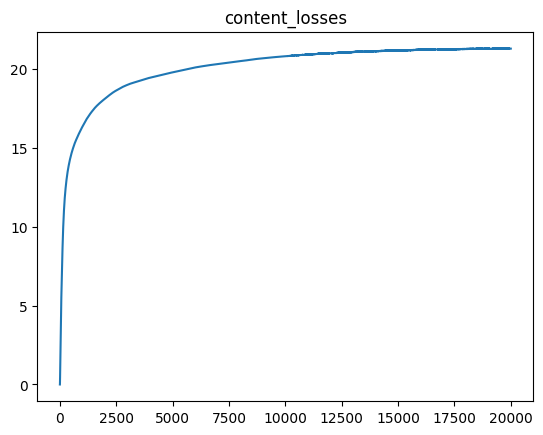

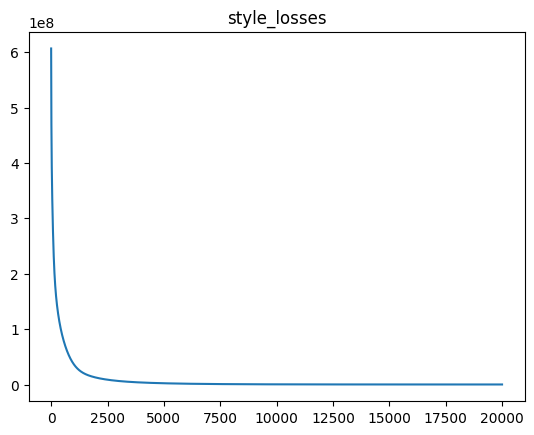

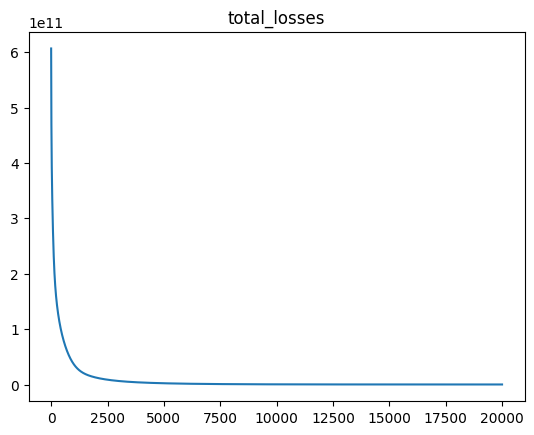

In [19]:
# Codeblock 18
plt.title('content_losses')
plt.plot(content_losses)
plt.show()

plt.title('style_losses')
plt.plot(style_losses)
plt.show()

plt.title('total_losses')
plt.plot(total_losses)
plt.show()